# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import time
import re
import pandas as pd
import numpy as np
import datetime

import random
random.seed(42)

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

#different libs
from functools import reduce


#pyspark libs
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

#pyspark ML imports
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier,  LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# Get the schema of the data
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Tabulated head through pandas
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
# Checking how many are null
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [7]:
# Explore the values of some categoric columns, check the number of different values for 1Hot Encoder
print(f"Tiers: {dfp.level.unique()}")
print(f"Method of communication: {dfp.method.unique()}")
print(f"Page: {dfp.page.unique()}")
print(f"Page status: {dfp.status.unique()}")
print(f"Gender: {dfp.gender.unique()}")
print(f"Auth status: {dfp.auth.unique()}")


Tiers: ['paid' 'free']
Method of communication: ['PUT' 'GET']
Page: ['NextSong' 'Add to Playlist' 'Roll Advert' 'Thumbs Up' 'Downgrade'
 'Thumbs Down' 'Home' 'Logout' 'Help' 'Login' 'Upgrade' 'Add Friend'
 'About' 'Settings' 'Submit Upgrade' 'Submit Downgrade' 'Error'
 'Save Settings' 'Cancel' 'Cancellation Confirmation' 'Register'
 'Submit Registration']
Page status: [200 307 404]
Gender: ['M' 'F' None]
Auth status: ['Logged In' 'Logged Out' 'Cancelled' 'Guest']


### Missing values in `userId`and `SessionId`



In [8]:
# Remove rows that have NaN in either userId or sessionId
num_rows = df.count()
print(f"There are {df.count()} rows in the dataset.")
df = df.dropna(how='any', subset=['userId', 'sessionId'])
print(f"There are {num_rows - df.count()} NaN's in either userId or sessionId. These rows are dropped.")

There are 286500 rows in the dataset.
There are 0 NaN's in either userId or sessionId. These rows are dropped.


In [9]:
# Preview the values of useId
df.select(['userId']).dropDuplicates().orderBy(df['userId']).show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



`userID` with empty strings are suspicious. Let's look directly at the `page` events for empty `userID`'s 

In [10]:
# Create a view to run SQL queries
df.createOrReplaceTempView("df_table")

In [11]:
# page events of users whose userId IS an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [12]:
# page events of users whose userId is NOT an empty string
spark.sql(
    '''
    SELECT DISTINCT page
    FROM df_table
    EXCEPT
    SELECT DISTINCT page
    FROM df_table
    WHERE userId == ""
    '''
).show()


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|             Upgrade|
|      Submit Upgrade|
+--------------------+



An userId of empty string likely represents user(s) who are in the middle of or prior to sign-in or registration. With some confidence of not influencing the result, we can drop there rows

In [13]:
# Drop rows that have empty userId
df = df.filter(df['userId'] != "")


In [14]:
df['lastName'] == ""

Column<b'(lastName = )'>

In [15]:
# Check the number of missing values in userId and sessionId
print("Number of missing values:")
for coln in ['userId', 'sessionId', 'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgent']:
    missing_count = df.filter((df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")


Number of missing values:
    userId: 0 missing values.
    sessionId: 0 missing values.
    firstName: 0 missing values.
    gender: 0 missing values.
    lastName: 0 missing values.
    location: 0 missing values.
    registration: 0 missing values.
    userAgent: 0 missing values.


In [16]:
# page events of null artist values
df.filter(df['artist'].isNull()).select(df['page']).dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



### Missing values in ``artist``, ``length``, ``song``

In [17]:
# page events of NOT null artist values
df.filter(df['artist'].isNotNull()).select(df['page']).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [18]:
# Check the number of missing values of artist, length, song columns when page event is "NextSong"
df_song = df.filter(df['page'] == "NextSong")
print("When page event is 'NextSong':")
for coln in ['artist', 'length', 'song']:
    missing_count = df_song.filter((df[coln].isNull()) | (df[coln] == "")).count()
    print(f"    {coln}: {missing_count} missing values.")



When page event is 'NextSong':
    artist: 0 missing values.
    length: 0 missing values.
    song: 0 missing values.


Now we can start exploring the cleaned dataset. We exclueded all missing values that can distorty further analysis.

# Exploratory Data Analysis

In a first step, let's explore the dataset with a small subset of the full dataset. We try to gather some first insights using basic statistics and try to come up with a way to measure the ``churn`` of our customers.


### To be deleted
### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
#Select all numerical columns

# Numerical columns (except for sessionId)
num_cols = ['itemInSession', 'registration', 'status', 'ts', 'length']


# Number of unique userId's to be sampled for exploratory data analysis
user_sample_size = 250

# Unique userId's from the full dataset
users = [row.userId for row in df.select('userId').dropDuplicates().collect()]

# Sample userId's
if len(users) > user_sample_size:
    user_sample = list(np.random.choice(users, size=user_sample_size, replace=False))
else:
    user_sample = list(np.copy(users))

# Create subset of the full dataset
df_sub = df.filter(df['userId'].isin(user_sample))

# Description of numerical cols
df_sub.select(num_cols).describe().show()


+-------+------------------+--------------------+------------------+--------------------+-----------------+
|summary|     itemInSession|        registration|            status|                  ts|           length|
+-------+------------------+--------------------+------------------+--------------------+-----------------+
|  count|            278154|              278154|            278154|              278154|           228108|
|   mean|114.89918174824018|1.535358834084427...|209.10321620397335|1.540958915431871...|249.1171819778458|
| stddev|  129.851729399489| 3.291321616327586E9|30.151388851328214|1.5068287123306298E9|99.23517921058361|
|    min|                 0|       1521380675000|               200|       1538352117000|          0.78322|
|    max|              1321|       1543247354000|               404|       1543799476000|       3024.66567|
+-------+------------------+--------------------+------------------+--------------------+-----------------+



In [20]:
# Possible values of status
coln = 'status'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

Possible values of 'status':
[307, 404, 200]


``status`` values store the possible HTTP responses, hence we can consider it as a categorical variable

In [21]:
# Numerical columns (except for sessionId)
num_cols = ['itemInSession', 'registration', 'ts', 'length']

Let's look closer at the categorical values

In [22]:
# Non-numerical columns (except for userId)
cat_cols = ['artist', 'auth', 'firstName', 'lastName', 'gender', 'level', 'location',
            'method', 'page', 'song', 'userAgent']


In [23]:
#Possible values of all cats

# Possible values of auth
coln = 'auth'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

# Possible values of gender
coln = 'gender'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

# Possible values of level
coln = 'level'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

# Possible values of method
coln = 'method'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

# Possible values of page
coln = 'page'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()])

# Possible values of userAgent
coln = 'userAgent'
print(f"Possible values of '{coln}':")
print([x[coln] for x in df_sub.select(coln).dropDuplicates().collect()[:10]])

# A status of 404 corresponds to a page event "Error"
df_sub.select(['status', 'page']).where(df_sub['status']==404).dropDuplicates().show()


Possible values of 'auth':
['Cancelled', 'Logged In']
Possible values of 'gender':
['F', 'M']
Possible values of 'level':
['free', 'paid']
Possible values of 'method':
['PUT', 'GET']
Possible values of 'page':
['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']
Possible values of 'userAgent':
['"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', 'Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWe

## Defining churn

Looking at the dataset, the most sense to define churn if by looking at the ``Cancellation Confirmation`` events. This happens for both paid and free users.

In [24]:
# check Cancellation Confirmation page
df.select("page").dropDuplicates().show()


+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [25]:
# number of users who churned
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [26]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



In [24]:
# flag the records where Cancellation Confirmation page is reached - 1 if it is and 0 if not
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# sort records for a user in reverse time order so we can add up vals in churn column
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)



In [25]:
#creating churn column
df = df.withColumn("churn", churn_event("page"))

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [26]:
# create column churn which contains sum of churn 1s over records
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [27]:
# groupby churn to get counts
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



### EDA for Users that Stayed vs Users that Churned

Now we can examine behaviour of those who churned vs those who did not churn. First we will visualise those who churned vs those who stayed.



In [28]:
# convert to pandas for visualisation
df_churn = df_churn.toPandas()

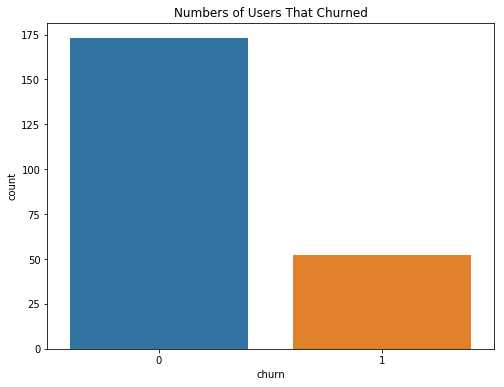

In [29]:
# plot the number of users that churned
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_churn, x = 'churn', y='count')
plt.title("Numbers of Users That Churned");

In [30]:
print(f"The churn rate is {52/(173+52) * 100}")

The churn rate is 23.11111111111111


### Length of time: Users that Churned vs. Users that Stayed

We can now look at the length distribution for customers who stayed and those which churned.

In [31]:
# get those customers who churned
df_len = df.filter(df.churn ==1)

# convert to pandas
df_pd = df_len.toPandas()

# drop the nulls
df_pd.length.dropna(inplace=True)

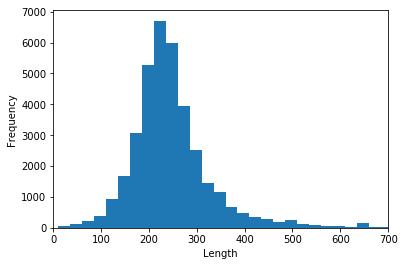

In [32]:

# plot the distribution
bin_edges = np.arange (10, df_pd['length'].max()+25, 25)
plt.hist(data = df_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency');

In [33]:
# users who stayed
df_len_stay = df.filter(df.churn ==0)

# convert to pandas
df_pd = df_len_stay.toPandas()

# drop nulls
df_pd.length.dropna(inplace=True)

### Gender - Users who Churned vs Users who Stayed
Now we can examine if gender had an effect on users that churned vs. those that stayed.

In [34]:
# create gender df grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

# show gender df 
df_gender.show()

# convert to pandas for visualisation
df_gender = df_gender.toPandas()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



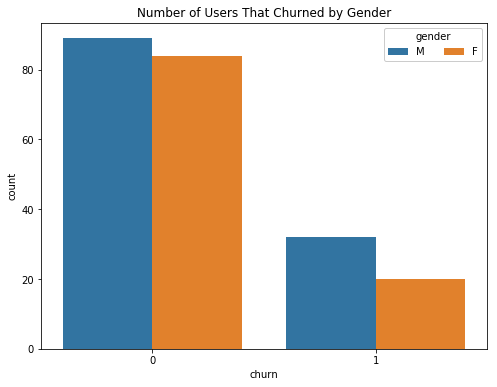

In [35]:
# order for the visualisation
df_gender = df_gender.sort_values('count', ascending = False)

# seaborn barplot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender, x = 'churn', y='count', hue = 'gender')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of Users That Churned by Gender");

In [36]:
print(f"We can see the male churn rate is at {32/(89+32)}, while the womans churn rate is at {20/(20+84)}")

We can see the male churn rate is at 0.2644628099173554, while the womans churn rate is at 0.19230769230769232


### Users who Churned vs Stayed by Level
Next we can examine if level has an effect on whether a user will churn or not. By level here we mean if the user paid for the app or if they used it for free with ads.

In [37]:
# create the level dataframe
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

df_level.show()

# convert to pandas for visualisation
df_level = df_level.toPandas()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



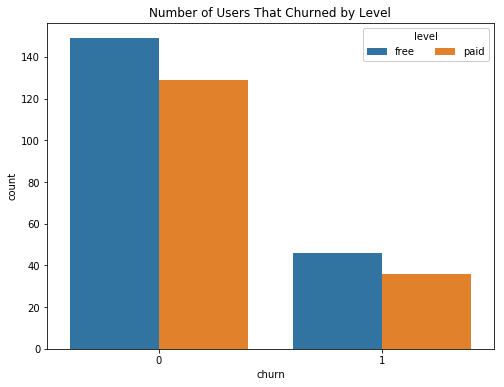

In [38]:
# plot the barplot using seaborn
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level, x = 'churn', y='count', hue = 'level')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of Users That Churned by Level");

In [39]:
print(f"We can see the level churn rate is at {46/(46+149)} for the free users, while the paid churn rate is at {36/(129+36)}")

We can see the level churn rate is at 0.2358974358974359 for the free users, while the paid churn rate is at 0.21818181818181817


### Pages Visited by Those that Churned vs. Those That Stayed
Next we can examine if there were different pages visited by users that churned compared to those that remained.

In [40]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

df_page.show(40)

# convert to pandas
df_page = df_page.toPandas()

+--------------------+-----+------+
|                page|churn| count|
+--------------------+-----+------+
|            Settings|    0|  1244|
|         Thumbs Down|    1|   496|
|           Thumbs Up|    1|  1859|
|     Add to Playlist|    1|  1038|
|               Error|    1|    32|
|               About|    1|    56|
|         Thumbs Down|    0|  2050|
|         Roll Advert|    1|   967|
|                Home|    0|  8410|
|Cancellation Conf...|    1|    52|
|               Error|    0|   220|
|              Cancel|    1|    52|
|            Settings|    1|   270|
|          Add Friend|    1|   636|
|             Upgrade|    0|   387|
|           Downgrade|    1|   337|
|              Logout|    1|   553|
|    Submit Downgrade|    1|     9|
|       Save Settings|    0|   252|
|           Thumbs Up|    0| 10692|
|           Downgrade|    0|  1718|
|      Submit Upgrade|    0|   127|
|         Roll Advert|    0|  2966|
|    Submit Downgrade|    0|    54|
|              Logout|    0|

In [41]:
# create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

In [42]:
# calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])) 

In [46]:
df_page.head(40)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


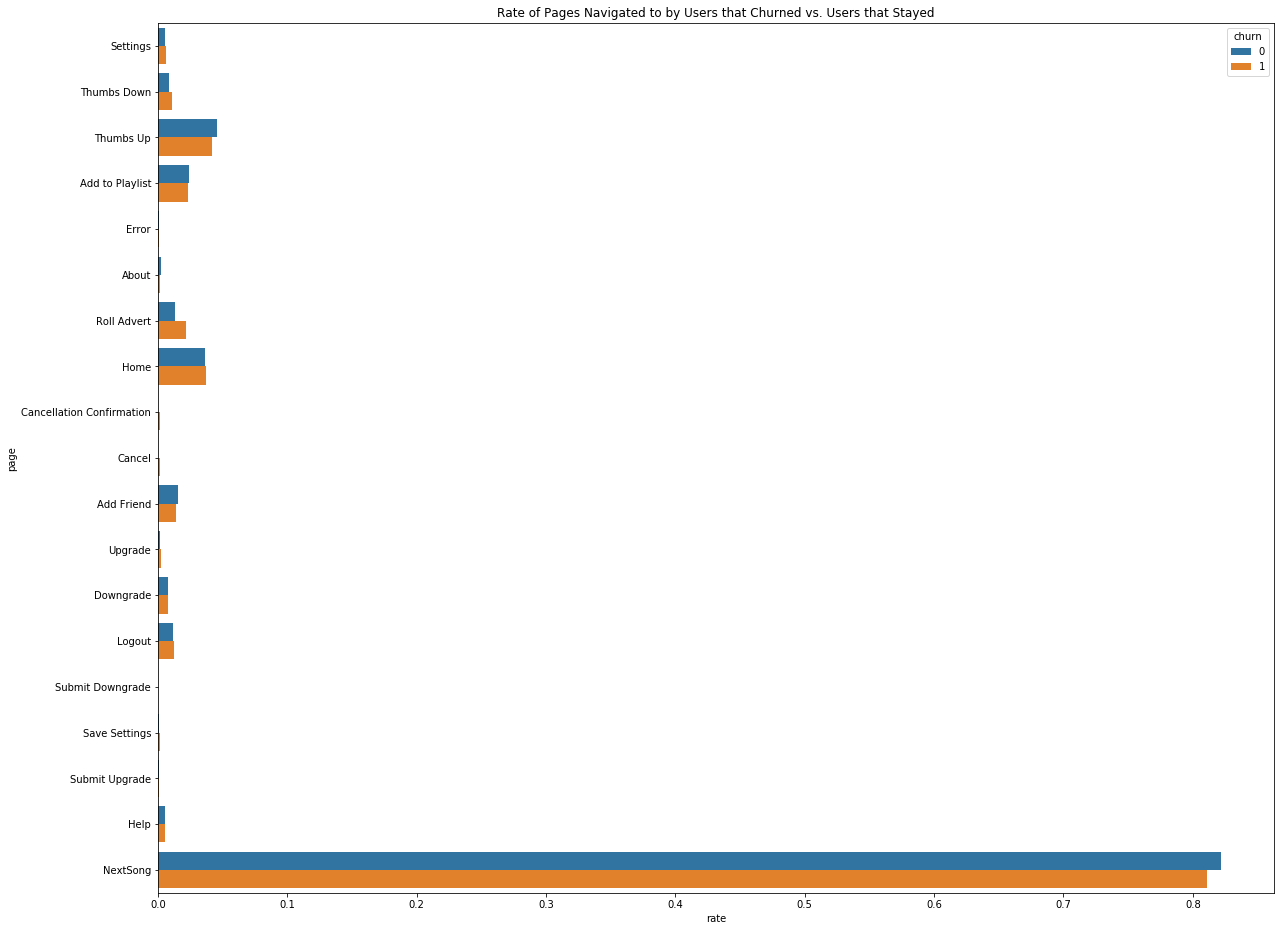

In [43]:
# plot the pages by churn
plt.figure(figsize=[20,16])
sns.barplot(data = df_page, x = 'rate', y = 'page', hue = 'churn')
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed');

From the above chart, we can see that the most popular action for both users that stayed and those that churned was to skip to the next song. We can also see that churned users rolled the ad and thumbs down songs more. Those who were more likely to stay performed more thumbs up actions, added friends and also added songs to playlist.

### Calculating Songs per Hour
We can now turn our attention to calculating the number of songs listened to by churn and non churn users per hour.

In [44]:

# get hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

# create hour column
df = df.withColumn("hour", get_hour(df.ts))

df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18')

In [45]:
# create a df with those who didnt churn and which counts when user goes to next song page
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [50]:
songs_in_hour_stay.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 7527|
|   1| 7035|
|   2| 7014|
|   3| 7063|
|   4| 6914|
|   5| 6960|
|   6| 6836|
|   7| 6873|
|   8| 7023|
|   9| 7268|
|  10| 7502|
|  11| 7440|
|  12| 7918|
|  13| 8073|
|  14| 8792|
|  15| 9462|
|  16| 9721|
|  17| 9464|
|  18| 9146|
|  19| 9112|
|  20| 9107|
|  21| 8853|
|  22| 8526|
|  23| 8085|
+----+-----+



In [46]:
# convert to pandas and then to numeric
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)
songs_in_hour_stay_pd

,hour,count
0,0,7527
1,1,7035
2,2,7014
3,3,7063
4,4,6914
5,5,6960
6,6,6836
7,7,6873
8,8,7023
9,9,7268


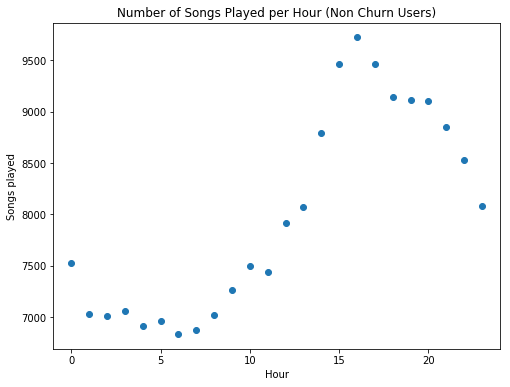

In [47]:
#plot the distribution
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_stay_pd["hour"], songs_in_hour_stay_pd["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour (Non Churn Users)");

From above we can see that there is a peak of songs played between 3pm and 8pm. Next we will examine users who churned by using the same process.

In [48]:
# dataframe with customers who churned and count next song page 
songs_in_hour_churned = df.filter((df.page == "NextSong") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [49]:
songs_in_hour_churned.show()

# convert to pandas and to numeric

songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned.hour = pd.to_numeric(songs_in_hour_churned.hour)

+----+-----+
|hour|count|
+----+-----+
|   0| 1535|
|   1| 1353|
|   2| 1322|
|   3| 1292|
|   4| 1233|
|   5| 1218|
|   6| 1218|
|   7| 1218|
|   8| 1230|
|   9| 1230|
|  10| 1380|
|  11| 1390|
|  12| 1408|
|  13| 1571|
|  14| 1702|
|  15| 1892|
|  16| 1915|
|  17| 1996|
|  18| 1978|
|  19| 1818|
+----+-----+
only showing top 20 rows



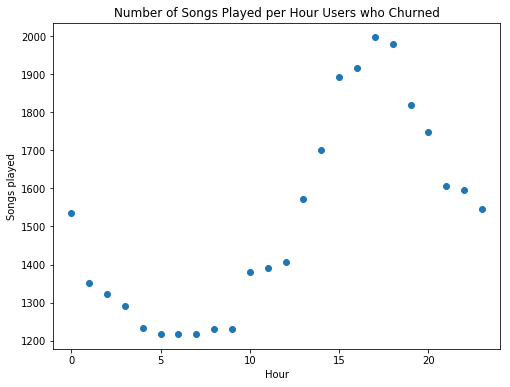

In [50]:
#plot distribution of songs per hour for churned
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_churned["hour"], songs_in_hour_churned["count"])
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned");

We can see users that churned had a similar distribution, however they listened to fewer songs per hour than users that stayed.

### Songs Per Session for Users who Churned vs. Those who Stayed
We can plot this in a simple way which will allow us to compare those who churned and those who stayed in a bar chart by getting the averages for both groups.

In [51]:
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()


# get average grouped by churn
df_songs.groupby('churn').agg({"count":"avg"}).show()

df_songs = df_songs.groupby('churn').agg({"count":"avg"})

# convert this to pandas df
df_songs = df_songs.toPandas()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



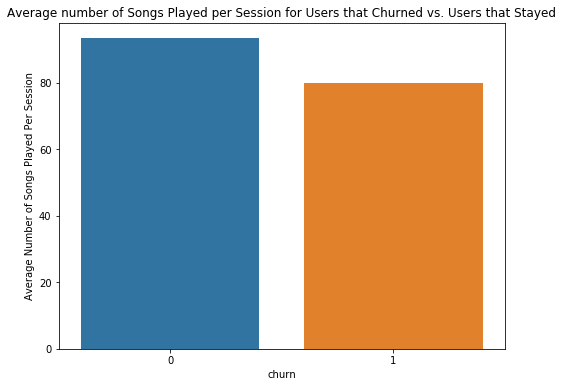

In [52]:
#plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_songs, x = 'churn', y='avg(count)')
plt.title("Average number of Songs Played per Session for Users that Churned vs. Users that Stayed")
plt.ylabel("Average Number of Songs Played Per Session");

From the chart we can see that those churned from Sparkify actually listening to fewer songs on average per session.

### Number of Unique Artists Listened to

We can create a similar chart for the number of artists that users listened to.

In [53]:
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

# get averages
df_artists.groupby('churn').agg({"count":"avg"}).show()


# convert to pandas
df_artists = df_artists.toPandas()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



Text(0.5,1,'Number of Artists Listened to on Sparkify')

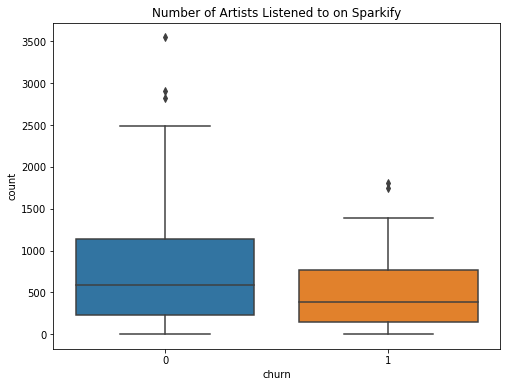

In [54]:
#plot boxplot
plt.figure(figsize = [8,6])
ax = sns.boxplot(data = df_artists, x = 'churn', y='count')
plt.title("Number of Artists Listened to on Sparkify")

### Location

We can now examine if location had an effect on churn.

In [55]:
df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



In [56]:
# get last two characters
get_state = udf(lambda x: x[-2:])


# create state column
df_state = df.withColumn("state", get_state(df.location))


# check that create state column worked
df_state.take(2)

df_state = df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()

# convert to pandas 
df_state_pd = df_state.toPandas()

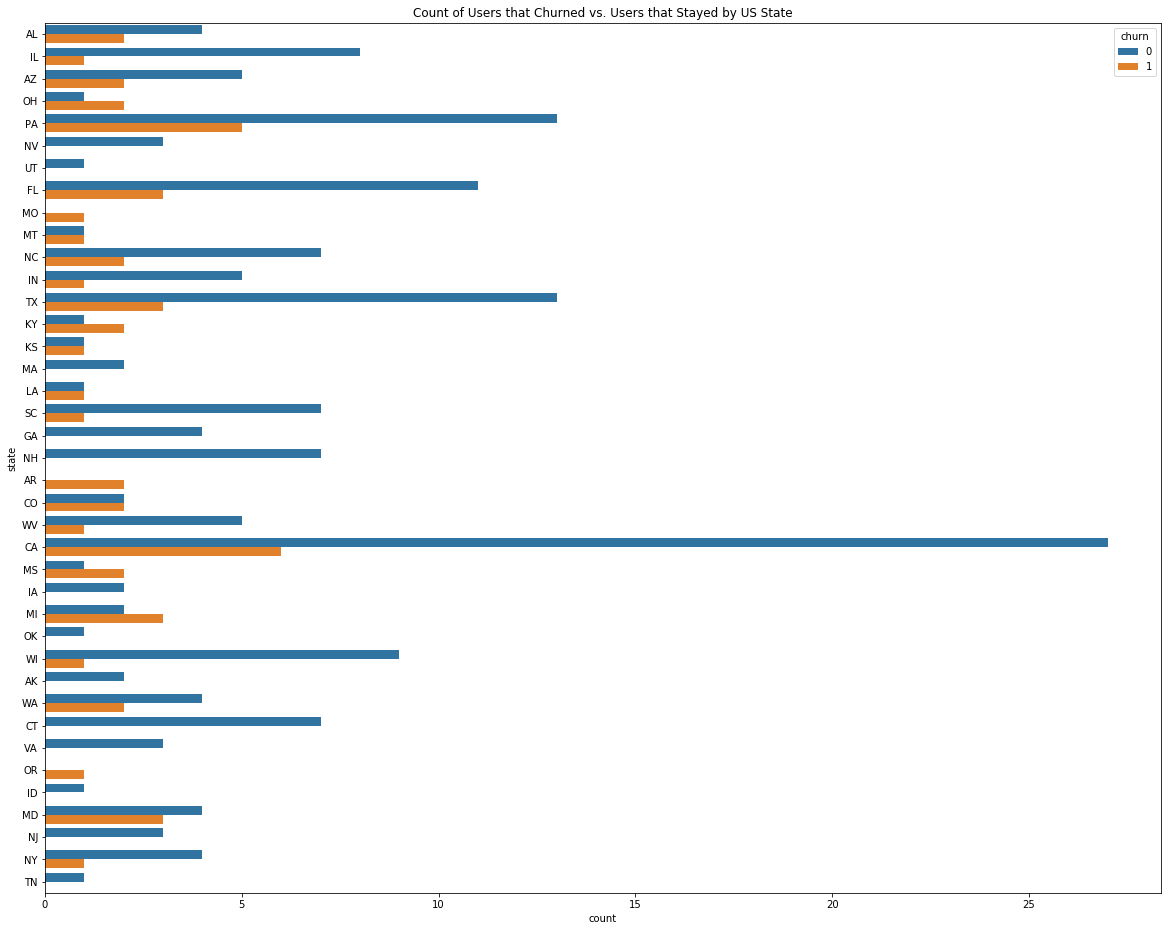

In [57]:
# plot 
plt.figure(figsize=[20,16])
sns.barplot(data = df_state_pd, x = 'count', y = 'state', hue = 'churn')
plt.title('Count of Users that Churned vs. Users that Stayed by US State');

Most users were based in CA. More users in MI, KY, and OH states churned than stayed. This may be difficult to engineer a useful feature for when it comes to modelling. Let's leave this for now and move onto another column from our dataset; operating systems and browsers.

### UserAgent: Operating System and Browsers
Now we can extract the Operating System a user is on to understand if this has an effect on churn.

In [58]:
df_opsys = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])
df_opsys.show()


# convert to pandas
df_opsys = df_opsys.toPandas()

# get the possible list of operating systems
df_opsys.userAgent.value_counts()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|100010|"Mozilla/5.0 (iPh...|    0|
|200002|"Mozilla/5.0 (iPh...|    0|
|   125|"Mozilla/5.0 (Mac...|    1|
|   124|"Mozilla/5.0 (Mac...|    0|
|    51|"Mozilla/5.0 (Win...|    1|
|     7|Mozilla/5.0 (Wind...|    0|
|    15|"Mozilla/5.0 (Win...|    0|
|    54|Mozilla/5.0 (Wind...|    1|
|   155|"Mozilla/5.0 (Win...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|   132|"Mozilla/5.0 (Mac...|    0|
|   154|"Mozilla/5.0 (Win...|    0|
|   101|Mozilla/5.0 (Wind...|    1|
|    11|Mozilla/5.0 (Wind...|    0|
|   138|"Mozilla/5.0 (iPa...|    0|
|300017|"Mozilla/5.0 (Mac...|    0|
|100021|"Mozilla/5.0 (Mac...|    1|
|    29|"Mozilla/5.0 (Mac...|    1|
|    69|"Mozilla/5.0 (Win...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
+------+--------------------+-----+
only showing top 20 rows



"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                24
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       18
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     16
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     12
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"                        10
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"             

In [59]:
# create list of operating systems
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]

# create os column and extract strings that match our os_list and add to column 
df_opsys['os'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

# check that worked
df_opsys

,userId,userAgent,churn,os
0,100010,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0,iPhone
1,200002,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like M...",0,iPhone
2,125,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
3,124,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",0,Mac
4,51,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows
5,7,Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20...,0,Windows
6,15,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0,Windows
7,54,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,1,Windows
8,155,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",0,Windows
9,100014,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1,Windows


In [60]:
df_opsys.os.value_counts()


# order for the plot
os_order = df_opsys.os.value_counts().index

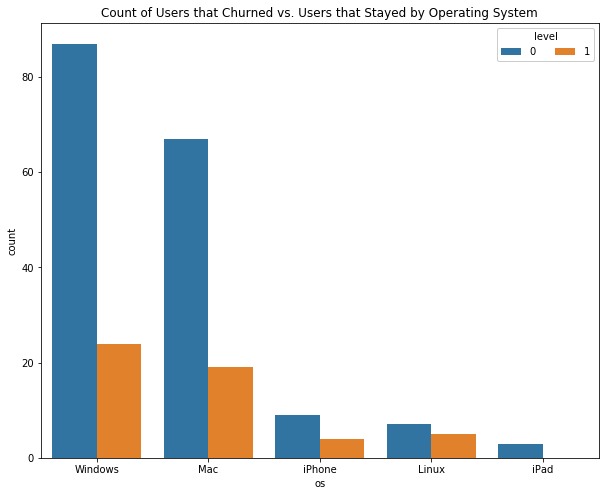

In [61]:
# plot count for churn and non churn users
plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'os', hue ='churn', order = os_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Operating System')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Windows was the most used. Linux users have the highest rate of churn. It is very few customers that this has affected therefore this won't be used in our model.

We can also look if browsers had an effect on churn using the same process.

In [62]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

df_opsys['browser'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

df_opsys.browser.value_counts()

df_opsys['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)

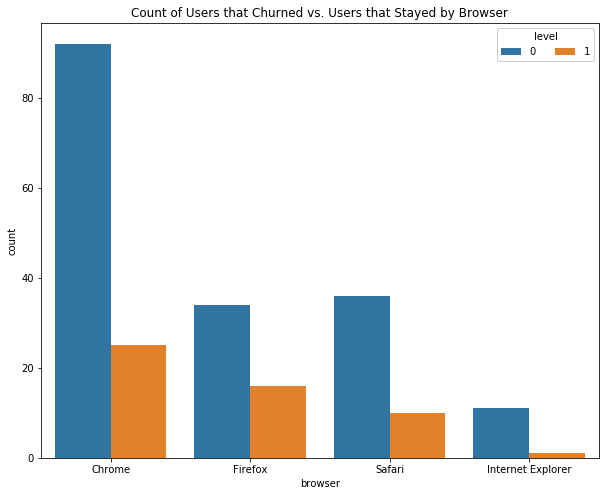

In [63]:
# order for the plot
browser_order = df_opsys.browser.value_counts().index

plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'browser', hue ='churn', order = browser_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Chrome was the most popular browser. Firefox users were most likely to churn. Internet Explorer had the fewest number of users that churned. There is no clear issue with browsers which is making users churn. Therefore this won't be used in our model.

### Days Since Registration for Sparkify
Finally, we can look at the number of days since a user had registered.

In [64]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

# order by last timestamp
w = Window.partitionBy("userId").orderBy(desc("ts"))

# create a rank with the most recent timestamp as rank number 1
df_days = df_days.withColumn("Rank", dense_rank().over(w))

df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [65]:
# just get those with a rank of 1 i.e the first rows
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

# need to minus the registration from ts 
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

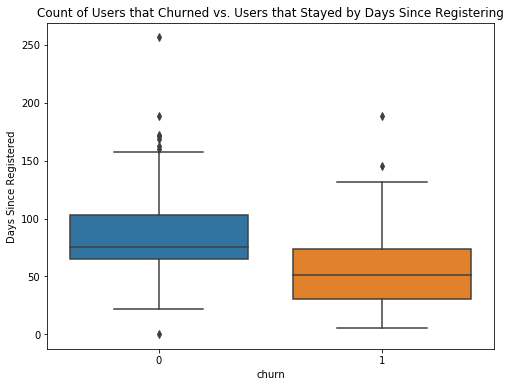

In [66]:
# to Pandas for the plot
df_days_pd = df_days.toPandas()

# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df_days_pd, x = 'churn', y ='days')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered");

On average those who had been registered with Sparkify for longer were more likely to stay. Users who had registered more recently were more likely to churn.



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Now that EDA has been performed, we can build out the features that seem most promising to train our model on.

The features we will build out are:

Categorical:

- gender

- level

Numerical:

- \# of songs per session

- \# of rollads actions

- \# of thumb down actions

- \# of thumbs up actions

- \# of friends added

- \# of songs added to playlist

- \# of different artists listened to on Sparkify

- \# of days since registration

We will also then add a churn label and join these all together. This will create a dataFrame where each row represents information pertaining to each individual user. Once we drop the userId, this dataframe can be vectorised, standarised and fed into our different machine learning algorithms.

First we will take our categorical variables and convert these into numeric variables, ready for our model.

#### Gender

Our first feature is gender which is a categorical one. We will assign a 1 for 'female' and a 0 for 'male'.

In [67]:
gender_f1 = df.select(['userId', 'gender']).dropDuplicates()

# create gender column 
gender_f1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

gender_f1.count()

# check
gender_f1.show(20)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|100010|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   116|     1|
|200001|     0|
|200020|     0|
|100008|     1|
|200015|     0|
|   100|     0|
|100006|     1|
|300005|     1|
|    25|     1|
+------+------+
only showing top 20 rows



#### Level
The next feature we will take is level. The level can change so we need to only take the most recent. We can use the rank trick from before.

In [68]:

df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

w = Window.partitionBy("userId").orderBy(desc("ts"))

df2 = df2.withColumn("Rank", dense_rank().over(w))

df2.show()

level_f2 = df2.filter(df2.Rank == 1).drop(df2.Rank)

level_f2 = level_f2.drop('ts')
level_f2 = level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))
level_f2.show(20)

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|

#### Average Number of songs per session

Our third feature is average number of songs per session for each user.

In [69]:
song_f3 = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

song_f3 = song_f3.groupby('userId').agg({"count":"avg"})

song_f3 = song_f3.withColumnRenamed("avg(count)", "avg_song")

song_f3.count()

song_f3.show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



#### Number of rollads actions
Next feature we can consider is number of roll advert actions. This had a higher number of roll ad count for those who churned since those who use the app for free are shown ads whereas paid subscribers aren't shown ads.

In [70]:
rollad_f4 = df.select(["userId", "page"])

rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

#creating rollad column
rollad_f4 = rollad_f4.withColumn("rollad", rollad_event("page"))

rollad_f4 = rollad_f4.groupby('userId').sum("rollad")

rollad_f4 = rollad_f4.withColumnRenamed("sum(rollad)", "roll_ad")

rollad_f4.count()

rollad_f4.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|100010|     52|
|200002|      7|
+------+-------+
only showing top 2 rows



#### Number of thumb down actions
The fifth feature we can add to our feature dataframe is thumbs down. Users who had churned in the past had performed more thumbs down actions than those who stayed with the service.

In [71]:
thumbdown_f5 = df.select(["userId", "page"])

thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

thumbdown_f5 = thumbdown_f5.withColumn("Thumbs Down", thumddown_event("page"))

thumbdown_f5 = thumbdown_f5.groupby('userId').sum("Thumbs Down")

thumbdown_f5 = thumbdown_f5.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

thumbdown_f5.count()

thumbdown_f5.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
+------+-----------+
only showing top 2 rows



#### Number of thumbs up actions
We can do the same for thumb up actions. Users who stayed with the service had performed more thumbs up actions in the past.

In [72]:
thumbup_f6 = df.select(["userId", "page"])

thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

thumbup_f6 = thumbup_f6.withColumn("Thumbs Up", thumbup_event("page"))

thumbup_f6 = thumbup_f6.groupby('userId').sum("Thumbs Up")

thumbup_f6 = thumbup_f6.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

thumbup_f6.count()

thumbup_f6.show(2)


+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
+------+---------+
only showing top 2 rows



#### Number of friends added
Similarly, number of friends added can indicate if a user is likely to churn or not. In the past, those who added more friends stayed with the app.

In [73]:
friend_f7 = df.select(["userId", "page"])
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
friend_f7 = friend_f7.withColumn("add_friend", add_friend("page"))
friend_f7 = friend_f7.groupby('userId').sum("add_friend")
friend_f7 = friend_f7.withColumnRenamed("sum(add_friend)", "add_friend")
friend_f7.count()
friend_f7.show(2)

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
+------+----------+
only showing top 2 rows



#### Number of songs added to playlist
Again, those who added more songs to their playlists had stayed with the service so this can provide an indication of whether a user is likely to churn.

In [74]:
playlist_f8 = df.select(["userId", "page"])
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
playlist_f8 = playlist_f8.withColumn("Playlist", add_playlist("page"))
playlist_f8 = playlist_f8.groupby('userId').sum("Playlist")
playlist_f8 = playlist_f8.withColumnRenamed("sum(Playlist)", "playlist")
playlist_f8.count()
playlist_f8.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
+------+--------+
only showing top 2 rows



#### Number of different Artists Listened to on Sparkify
As we discovered in EDA, users that listened to more diverse artists were less likely to churn.

In [75]:
artists_f9 = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
artists_f9 = artists_f9.withColumnRenamed("count", "num_artists")
artists_f9.count()
artists_f9.show(2)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



#### Number of Days Since Registering
Number of days since registering also looked useful from our EDA. We saw that users who had a shorter number of days since registering churned more than those who had used the service for a longer time.

In [76]:
df_days.show()

days_f10 = df_days.drop('registration', 'ts', 'churn', 'delta_days')
days_f10.count()
days_f10.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

#### Label
Now we can create our label column indicating if the user churned (1) or not (0).

In [77]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
label = label.drop('count')
label.count()
label = label.withColumnRenamed("churn", "label")
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



### Create Features Dataset
Now that we have our features we need to join these together on userId.


In [78]:

feature_df = gender_f1.join(level_f2, ["userId"]).join(song_f3, ["userId"]).join(rollad_f4, ["userId"]).join(thumbdown_f5, ["userId"]).join(thumbup_f6, ["userId"]).join(friend_f7, ["userId"]).join(playlist_f8, ["userId"]).join(artists_f9, ["userId"]).join(days_f10, ["userId"]).join(label, ["userId"])
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|100010|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253|  55.6436574074074|    0|
|200002|     0|    1|              64.5|      7|          6|       21|         4|       8|        340| 70.07462962962963|    0|
|   125|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    1|
|   124|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|       2233|131.55591435185184|    0|
|    51|     0|    1|             211.1|      0|         21|      100|        28|      52|       1386|19

In [79]:
# Dropping the user id
feature_df = feature_df.drop('userId')
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|     1|    0|39.285714285714285|     52|          5|       17|         4|       7|        253|  55.6436574074074|    0|
|     0|    1|              64.5|      7|          6|       21|         4|       8|        340| 70.07462962962963|    0|
|     0|    0|               8.0|      1|          0|        0|         0|       0|          9| 71.31688657407408|    1|
|     1|    1|145.67857142857142|      4|         41|      171|        74|     118|       2233|131.55591435185184|    0|
|     0|    1|             211.1|      0|         21|      100|        28|      52|       1386|19.455844907407407|    1|
|     0|    0|21.428571428571427

### Preprocessing


In [80]:
# print schema
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



Now we need to take these columns and convert into the numerical datatypes that will be used in our model: integers and floats. We can use write a function to adhere to DRY principles.


In [81]:
for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))
#check this works
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- roll_ad: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- add_friend: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)




The next stage of preprocessing is to vectorise our features.

### Vector Assembler
The purpose of vector assembler is to tranform our features into a vector. The vector can then be standardised and fed into our chosen algorithms.



In [82]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vec_features")
feature_df = assembler.transform(feature_df)
#feature_df.show()

+------+-----+---------+-------+-----------+---------+----------+--------+-----------+----------+-----+--------------------+
|gender|level| avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|      days|label|        vec_features|
+------+-----+---------+-------+-----------+---------+----------+--------+-----------+----------+-----+--------------------+
|   1.0|  0.0|39.285713|   52.0|        5.0|     17.0|       4.0|     7.0|      253.0| 55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|    7.0|        6.0|     21.0|       4.0|     8.0|      340.0|  70.07463|  0.0|[0.0,1.0,64.5,7.0...|
|   0.0|  0.0|      8.0|    1.0|        0.0|      0.0|       0.0|     0.0|        9.0|  71.31689|  1.0|(10,[2,3,8,9],[8....|
|   1.0|  1.0|145.67857|    4.0|       41.0|    171.0|      74.0|   118.0|     2233.0| 131.55591|  0.0|[1.0,1.0,145.6785...|
|   0.0|  1.0|    211.1|    0.0|       21.0|    100.0|      28.0|    52.0|     1386.0| 19.455845|  1.0|[0.0,1.0,211.1000...|


### Standardisation
Now that we have our vectors we can standardise our values. This is important for our machine learning model so that those features with the highest values don't dominate the results and so that we can make the individual features look like standard normally distributed data.

In [83]:

scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)
scaler_model = scaler.fit(feature_df)
feature_df = scaler_model.transform(feature_df)
feature_df.head(2)

[Row(gender=1.0, level=0.0, avg_song=39.28571319580078, roll_ad=52.0, thumbs_down=5.0, thumbs_up=17.0, add_friend=4.0, playlist=7.0, num_artists=253.0, days=55.64365768432617, label=0.0, vec_features=DenseVector([1.0, 0.0, 39.2857, 52.0, 5.0, 17.0, 4.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0013, 0.0, 0.9219, 2.413, 0.3823, 0.2596, 0.1943, 0.214, 0.4189, 1.4775])),
 Row(gender=0.0, level=1.0, avg_song=64.5, roll_ad=7.0, thumbs_down=6.0, thumbs_up=21.0, add_friend=4.0, playlist=8.0, num_artists=340.0, days=70.07463073730469, label=0.0, vec_features=DenseVector([0.0, 1.0, 64.5, 7.0, 6.0, 21.0, 4.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0844, 1.5135, 0.3248, 0.4588, 0.3207, 0.1943, 0.2445, 0.563, 1.8606]))]

### Train / Test / Validation Split
Let's check how many records we have in total is 225 as it should be.



In [89]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



This count is what we would expect, now we can split our data into train, test and validation sets. Here we will do a 60:20:20 split and include a seed so we can reproduce the result. I've included the same seed for the different machine learning models so that my results can be reproduced.


In [84]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2], seed = 1996)

# Modeling

Now we have created our features dataFrame with only numeric variables, we can split the full dataset into train, test, and validation sets. We will test out different machine learning classification algorithms including:

Logistic Regression
Random Forest Classifier
Gradient-Boosted Tree Classifier
Linear Support Vector Machine
Naive Bayes
We will use these classification algorithms since churn prediction is a binary classification problem, meaning that customers will either churn (1) or they will stay (0) in a certain period of time.

### Metrics
We will evaluate the accuracy of the various models, tuning parameters as necessary. We will finally determine our winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I will use F1 score as the metric to optimize. F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes like we have here.

Now we can start modelling. When we identify the model with the best F1 score, accuracy and time we will then tune the model.

The models I have selected are below with the reasons why these have been chosen. Each model that has been chosen is suitable for our binary classification problem of predicting churn.

- Logistic Regression: Logistic regression is the first machine learning algorithm we can try. Logistic regression is a reliable machine learning algorithm to try since this is a binary classification problem and logistic regression provides a model with good explainability. Logistic regression is also easy to implement, interpret and is efficient to train. It is also less inclined to overfitting.
- Random Forest: Random Forest is a powerful supervised learning algorithm that can be used for classification. RF is an ensemble method that creates multiple decision trees to make predictions and takes a majority vote of decisions reached. This can help avoid overfitting. RF is also robust and has good performance on imbalanced datasets like we have here.
- Gradient Boosted Tree Classifier: GBT provides good predictive accuracy. This works by building one tree at a time where each new tree helps correct errors made by the previous tree compared to RF which builds trees independently. There is a risk of overfitting with GBT so this needs to be considered. However GBT performs well with unbalanced data which we have here.
- Naive Bayes: Finally, we will try Naive Bayes. This is another classifier algorithm that is easy to implement and is fast.

### Training the Models & Evaluating the Model Performance
Steps:

Instantiate
- Fit Models on Train
- Predicting
- Evaluating

In [85]:
# instantiate all of our models and include a seed for reproduciblity where possible
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=42)
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10, seed=42)
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')


#list of models
model_list = [lr, rf, gbt, nb]

In [86]:

# evaluator we are using is multiclassclassificationevaluator to get the F1 scores
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [92]:
# for loop to go through all our models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(test)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 179.96244931221008 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.6523297491039427
The accuracy of the LogisticRegression model is: 0.7222222222222222
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 222.63657903671265 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.7693326709720152
The accuracy of the RandomForestClassifier model is: 0.8055555555555556
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 333.270690202713 seconds
GBTClassifier predicting started
GBTClassifier predicting ended
F1 for GBTClassifier is: 0.8888888888888888
The accuracy of the GBTClassifier model is: 0.8888888888888888
NaiveBayes training started
Nai

### Parameters
I will select maxDepth for our GBT model tuning.


MaxDepth: I have chosen a max of 8 to reduce the possibility of overfitting. 
Numfolds: I originally had numFolds = 5 but had to change to 3 to speed up the process.
The seed is fixed at 42.

In [100]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[2,4,8]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3,
                          seed = 42)

cvModel = crossval.fit(train)

In [101]:
cvModel.avgMetrics

[0.7977713786497604, 0.7290785872017431, 0.728929643873253]

### Model Tuning for Best Models:
Now we can tune our model using paramGridbuilder and CrossValidator. Grandient Boosted Tree Classifier had a F1 score of 0.88 and accuracy of 0.88 and took 333 seconds to train.

In [103]:
results = cvModel.transform(valid)


accuracy = results.filter(results.label == results.prediction).count() / (results.count())

best_model = cvModel.bestModel


print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Best Param (MaxDepth):  2
F1 for our best model is: 0.6805555555555557
Accuracy for our best model is: 0.7777777777777778


In [104]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.6805555555555557


### Feature Importance:
Finally, we can check the feature importance for our best model and plot this in a chart.

In [105]:
importances = best_model.featureImportances
x_values = list(range(len(importances)))
feature_list = list(["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"])

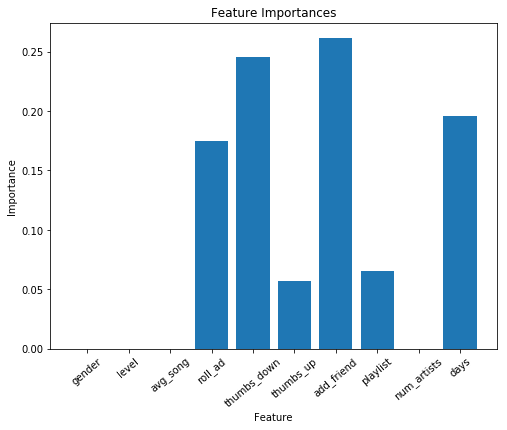

In [107]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

Here we can see that the feature with the highest importance was days since registered. Gender, level and num_artists were the least important features.



## Conclusions

We started the project with a small dataset of just 128MB and 225 unique customers. After loading and cleaning our data we explored the dataset for useful features to predict churn and were able to build out the most promising features. We then preprocessed these and used the features with different machine learning algorithms. GBT performed the best, so we tuned the model and achieved an accuracy of 0.78.

### Business Impact:
Now, Sparkify can use this information to target customers who are likely to churn and offer attractive incentives to stay, thereby saving Sparkify revenue and getting the customer a nice deal. Since we found that newer customers are more likely to churn, we could target them with a nice free trial of the premium service without those pesky ads! Sparkify could also work on music recommendation system so they can recommend songs that users will enjoy more and thumbs down less.

### Project Reflection
From this project I have learned how to manipulate datasets with Spark to engineer relevant features for predicting churn. I used Spark MLib to build machine learning models to predict churn. It was interesting to start with a dataset which had the customers' user interactions and then use this to predict whether or not they were likely to churn. The best model was the GBT classifier which achieved an accuracy of 0.78. It was interesting to build my first model for predicting churn in pyspark as opposed to pandas.

### Future Work
This project could have been improved by:

doing more feature engineering to select the best features to get a better score
considered overfitting problems in more depth
analysing mispredicted users

# References

Following material was consulted creating the notebook

https://stackoverflow.com/questions/46921465/extract-substring-from-text-in-a-pandas-dataframe-as-new-column
https://developers.whatismybrowser.com/useragents/explore/layout_engine_name/trident/
https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/
https://stackoverflow.com/questions/52943627/convert-a-pandas-dataframe-to-a-pyspark-dataframe
https://stackoverflow.com/questions/29600673/how-to-delete-columns-in-pyspark-dataframe
https://stackoverflow.com/questions/46956026/how-to-convert-column-with-string-type-to-int-form-in-pyspark-data-frame
https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221
https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression
https://spark.apache.org/docs/2.2.0/ml-classification-regression.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://www.silect.is/blog/random-forest-models-in-spark-ml/